<a href="https://colab.research.google.com/github/GHM-ML/Imersao-Dados-Alura/blob/main/Imers%C3%A3o_Dados_Alura_GHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalar ferramentas necessárias
!pip install geopandas
!pip install pygeos

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
pd.options.display.max_columns = None
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gpd.options.use_pygeos = True
# carregar todos datasets
dados = pd.read_csv("https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv")
ibge_sp = pd.read_csv(
    'https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv',
    encoding='ISO-8859-1',
    sep=';', thousands='.', decimal=','
)
enderecos = pd.read_csv('/content/drive/MyDrive/imersao_dados/enderecos.csv')
setor_censo = gpd.read_file('/content/drive/MyDrive/imersao_dados/35SEE250GC_SIR.shp')
dados_geo = pd.read_csv("/content/drive/MyDrive/imersao_dados/dados_geo.csv")


In [ ]:
ibge_sp.dropna(how='all', axis=1, inplace=True)

enderecos_sp = enderecos.query("sigla_uf == 'SP'")
enderecos_sp["rua"] = enderecos_sp["tipo_logr"] + " " + enderecos_sp["logr_nome"]
enderecos_sp["rua"] = enderecos_sp["rua"].str.lower().str.strip()

setor_censo_sp = setor_censo[setor_censo.NM_MUNICIP == "SÃO PAULO"]

In [ ]:
dados[['moeda','valor','tipo_anuncio']] = dados['Valor'].str.split(expand = True)

In [ ]:
dados_de_venda = dados.copy()
dados_de_venda = dados_de_venda[dados_de_venda['tipo_anuncio'].isnull() == True]

In [ ]:
def strip_dots(number):

  if number:
    parts_list = number.split('.')
    actual_number = ''.join(parts_list)
    return int(actual_number)

dados_de_venda['valor'] = dados_de_venda['valor'].apply(lambda x: strip_dots(x))

In [ ]:
dados_de_venda.describe()

,Metragem,Quartos,Banheiros,Vagas,valor
count,9156.00,9156.00,9156.00,9156.00,9156.00
mean,434.42,3.45,3.80,3.96,3052202.96
std,7856.42,1.05,1.97,2.60,3944208.19
min,10.00,1.00,1.00,1.00,13000.00
25%,168.00,3.00,2.00,2.00,890000.00
50%,276.00,3.00,4.00,4.00,1800000.00
75%,450.00,4.00,5.00,5.00,3500000.00
max,750000.00,16.00,40.00,50.00,65000000.00


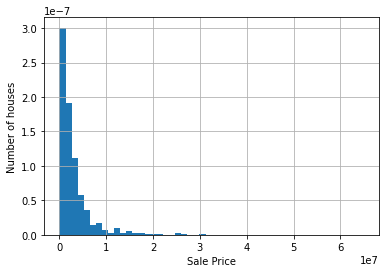

In [ ]:
dados_de_venda['valor'].hist(bins=50, density=True)
plt.ylabel('Number of houses')
plt.xlabel('Sale Price')    
plt.show()

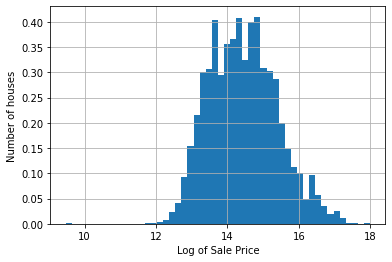

In [ ]:
np.log(dados_de_venda['valor']).hist(bins=50, density=True)
plt.ylabel('Number of houses')
plt.xlabel('Log of Sale Price')
plt.show()

In [ ]:
dados_de_venda["apenas_rua"] = dados_de_venda["Rua"].str.extract(r'(^[\w ]+)')
dados_de_venda["apenas_rua"] = dados_de_venda["apenas_rua"].str.lower().str.strip()

In [ ]:
# unir dados de venda aos dados dos endereços, pelo nome da rua
venda_geo = pd.merge(left = dados_de_venda, right = enderecos_sp[["rua", "cep", "latitude", "longitude"]], how = "left", left_on = "apenas_rua", right_on = "rua").drop_duplicates(subset=dados_de_venda.columns).query("cep > 0")


In [ ]:
venda_geo


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,moeda,valor,tipo_anuncio,apenas_rua,rua,cep,latitude,longitude
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,R$,7000000,None,avenida itacira,avenida itacira,11443160.00,-23.98,-46.20
5,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,R$,3700000,None,rua aurelia perez alvarez,rua aurelia perez alvarez,4642020.00,-23.64,-46.69
6,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,R$,380000,None,rua alba valdez,rua alba valdez,4845200.00,-23.75,-46.70
7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000,R$,685000,None,NaN,NaN,18125000.00,-23.53,-47.26
26,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,R$,540000,None,rua tobias barreto,rua tobias barreto,13474663.00,-22.70,-47.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89956,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000,R$,1500000,None,avenida odila,avenida odila,4058020.00,-23.61,-46.65
89958,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000,R$,665000,None,rua tapuçu,rua tapuçu,4671185.00,-23.66,-46.69
89959,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000,R$,2300000,None,rua guararema,rua guararema,13030640.00,-22.92,-47.08
89976,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000,R$,1050000,None,rua estero belaco,rua estero belaco,4145020.00,-23.62,-46.63


In [ ]:
# criar geodataframe para analisar a continência de um ponto de latitude/longitude em uma região 
# colocar o mesmo sistema de coordenadas para todos os geodataframes
geodf = gpd.GeoDataFrame(
    venda_geo, geometry=gpd.points_from_xy(venda_geo.longitude, venda_geo.latitude))
geodf = geodf.set_crs('epsg:4674')

In [ ]:
# sjoin une os datasets se o ponto na coluna 'geometry' estiver dentro da região no dataset da direita
geo_df_setores = gpd.sjoin(geodf,setor_censo_sp,how="left", predicate='intersects')
geo_df_setores['CD_GEOCODI'] = geo_df_setores['CD_GEOCODI'].astype('float64')

In [ ]:
dados_vendas_censo = geo_df_setores.merge(right = ibge_sp, how = "left", left_on = "CD_GEOCODI", right_on = "Cod_setor")

In [ ]:
geo_df_setores.reset_index()

,index,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,moeda,valor,tipo_anuncio,apenas_rua,rua,cep,latitude,longitude,geometry,index_right,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1
0,0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,R$,7000000,None,avenida itacira,avenida itacira,11443160.00,-23.98,-46.20,POINT (-46.20132 -23.97599),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,R$,3700000,None,rua aurelia perez alvarez,rua aurelia perez alvarez,4642020.00,-23.64,-46.69,POINT (-46.68831 -23.64096),57581.00,123076.00,355030871000023.00,URBANO,35503087100,None,355030871,SANTO AMARO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,57582.00
2,6,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,R$,380000,None,rua alba valdez,rua alba valdez,4845200.00,-23.75,-46.70,POINT (-46.69589 -23.75299),48704.00,114197.00,355030830000050.00,URBANO,35503083000,None,355030830,GRAJAÚ,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,48705.00
3,7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000,R$,685000,None,NaN,NaN,18125000.00,-23.53,-47.26,POINT (-47.25502 -23.53104),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,R$,540000,None,rua tobias barreto,rua tobias barreto,13474663.00,-22.70,-47.29,POINT (-47.29446 -22.69890),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,89956,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000,R$,1500000,None,avenida odila,avenida odila,4058020.00,-23.61,-46.65,POINT (-46.64726 -23.60909),58919.00,124444.00,355030877000099.00,URBANO,35503087700,None,355030877,SAÚDE,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,58920.00
8516,89958,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000,R$,665000,None,rua tapuçu,rua tapuçu,4671185.00,-23.66,-46.69,POINT (-46.69152 -23.66102),45382.00,110964.00,355030816000087.00,URBANO,35503081600,None,355030816,CAMPO GRANDE,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,45383.00
8517,89959,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000,R$,2300000,None,rua guararema,rua guararema,13030640.00,-22.92,-47.08,POINT (-47.07696 -22.92275),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8518,89976,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000,R$,1050000,None,rua estero belaco,rua estero belaco,4145020.00,-23.62,-46.63,POINT (-46.63298 -23.61612),58872.00,124397.00,355030877000052.00,URBANO,35503087700,None,355030877,SAÚDE,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,58873.00


In [ ]:
# variáveis inúteis são constantes ou inteiramente nulas, não servem de forma nenhuma para o modelo
def useless_variables(df):
    constants_list = []
    for column in df.columns:
        if df[column].nunique() <= 1:
             constants_list.append(column)
    return constants_list    

In [ ]:
useless_list = useless_variables(dados_vendas_censo)

In [ ]:
useless_list

['Cidade',
 'moeda',
 'tipo_anuncio',
 'NM_SUBDIST',
 'CD_GEOCODM',
 'NM_MUNICIP',
 'NM_MICRO',
 'NM_MESO',
 'CD_GEOCODB',
 'NM_BAIRRO',
 'Cod_Grandes Regiï¿½es',
 'Nome_Grande_Regiao',
 'Cod_UF',
 'Nome_da_UF ',
 'Cod_meso',
 'Nome_da_meso',
 'Cod_micro',
 'Nome_da_micro',
 'Cod_RM',
 'Nome_da_RM',
 'Cod_municipio',
 'Nome_do_municipio',
 'Cod_bairro',
 'Nome_do_bairro']

In [ ]:
dados_vendas_censo_wo_constants = dados_vendas_censo.drop(useless_list, axis = 1)

In [ ]:
dados_vendas_censo_wo_constants.isnull().sum()

Rua                    2881
Bairro                    8
Metragem                  0
Quartos                   0
Banheiros                 0
Vagas                     0
Valor                     0
valor                     0
apenas_rua             2881
rua                    2881
cep                       0
latitude                  0
longitude                 0
geometry                  0
index_right            4623
ID                     4623
CD_GEOCODI             4623
TIPO                   4623
CD_GEOCODS             4623
CD_GEOCODD             4623
NM_DISTRIT             4623
ID1                    4623
Cod_setor              4625
Cod_distrito           4625
Nome_do_distrito       4625
Cod_subdistrito        4625
Nome_do_subdistrito    4625
Situacao_setor         4625
Tipo_setor             4625
V001                   4625
V002                   4625
V003                   4625
V004                   4625
V005                   4625
V006                   4625
V007                

In [ ]:
# Verifica-se que o dataset contém várias variáveis com muitos valores nulos.
# Como geralmente o modelo responde melhor à maior disponibilidade de dados, vou usar o dataset 'dados_geo',
# que tem os dados dos quais preciso para enriquecer o modelo.


In [ ]:
dados_geo


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_anuncio,Tipo_anuncio,Valor_mm,Valor_m2,rua,cep,latitude,longitude,Point,setor_censo
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,7000000.00,NaN,7.00,7000.00,Avenida Itacira,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,3700000.00,NaN,3.70,7459.68,Rua Aurelia Perez Alvarez,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,380000.00,NaN,0.38,3040.00,Rua Alba Valdez,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,540000.00,NaN,0.54,5400.00,Rua Tobias Barreto,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000,1980000.00,NaN,1.98,4500.00,Rua Graham Bell,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000,1500000.00,NaN,1.50,5617.98,Avenida Odila,4058020.00,-23.61,-46.65,POINT (-46.6472577 -23.6090928),355030877000099.00
5601,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000,665000.00,NaN,0.67,7000.00,Rua Tapuçu,4671185.00,-23.66,-46.69,POINT (-46.6915206 -23.661018),355030816000087.00
5602,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000,2300000.00,NaN,2.30,3801.65,Rua Guararema,4136030.00,-23.41,-46.04,POINT (-46.0373872 -23.411688),NaN
5603,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000,1050000.00,NaN,1.05,5121.95,Rua Estero Belaco,4145020.00,-23.62,-46.63,POINT (-46.632983 -23.6161237),355030877000052.00


In [ ]:
dados_vendas_censo_alura = pd.merge(left = dados_geo, right = ibge_sp, how = "left", left_on = "setor_censo", right_on = "Cod_setor")
dados_vendas_censo_alura

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_anuncio,Tipo_anuncio,Valor_mm,Valor_m2,rua,cep,latitude,longitude,Point,setor_censo,Cod_setor,Cod_Grandes Regiï¿½es,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,Nome_da_RM,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,7000000.00,NaN,7.00,7000.00,Avenida Itacira,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00,355030877000067.00,3.00,Regiï¿½o Sudeste,35.00,Sï¿½o Paulo,3515.00,Metropolitana de Sï¿½o Paulo,35061.00,Sï¿½o Paulo,20.00,RM Sï¿½o Paulo,3550308.00,Sï¿½O PAULO,355030877.00,SAï¿½DE,35503087700.00,SAï¿½DE,3550308000.00,Sï¿½O PAULO (todos os setores),1.00,0.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,3700000.00,NaN,3.70,7459.68,Rua Aurelia Perez Alvarez,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00,355030871000023.00,3.00,Regiï¿½o Sudeste,35.00,Sï¿½o Paulo,3515.00,Metropolitana de Sï¿½o Paulo,35061.00,Sï¿½o Paulo,20.00,RM Sï¿½o Paulo,3550308.00,Sï¿½O PAULO,355030871.00,SANTO AMARO,35503087100.00,SANTO AMARO,3550308000.00,Sï¿½O PAULO (todos os setores),1.00,0.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,380000.00,NaN,0.38,3040.00,Rua Alba Valdez,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00,355030830000050.00,3.00,Regiï¿½o Sudeste,35.00,Sï¿½o Paulo,3515.00,Metropolitana de Sï¿½o Paulo,35061.00,Sï¿½o Paulo,20.00,RM Sï¿½o Paulo,3550308.00,Sï¿½O PAULO,355030830.00,GRAJAï¿½,35503083000.00,GRAJAï¿½,3550308000.00,Sï¿½O PAULO (todos os setores),1.00,0.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,540000.00,NaN,0.54,5400.00,Rua Tobias Barreto,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00,355030808000050.00,3.00,Regiï¿½o Sudeste,35.00,Sï¿½o Paulo,3515.00,Metropolitana de Sï¿½o Paulo,35061.00,Sï¿½o Paulo,20.00,RM Sï¿½o Paulo,3550308.00,Sï¿½O PAULO,355030808.00,BELï¿½M,35503080800.00,BELï¿½M,3550308000.00,Sï¿½O PAULO (todos os setores),1.00,0.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000,1980000.00,NaN,1.98,4500.00,Rua Graham Bell,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00,355030865000169.00,3.00,Regiï¿½o Sudeste,35.00,Sï¿½o Paulo,3515.00,Metropolitana de Sï¿½o Paulo,35061.00,Sï¿½o Paulo,20.00,RM Sï¿½o Paulo,3550308.00,Sï¿½O PAULO,355030865.00,RAPOSO TAVARES,35503086500.00,RAPOSO TAVARES,3550308000.00,Sï¿½O PAULO (todos os setores),1.00,0.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000,1500000.00,NaN,1.50,5617.98,Avenida Odila,4058020.00,-23.61,-46.65,POINT (-46.6472577 -23.6090928),355030877000099.00,355030877000099.00,3.00,Regiï¿½o Sudeste,35.00,Sï¿½o Paulo,3515.00,Metropolitana de Sï¿½o Paulo,35061.00,Sï¿½o Paulo,20.00,RM Sï¿½o Paulo,3550308.00,Sï¿½O PAULO,355030877.00,SAï¿½DE,35503087700.00,SAï¿½DE,3550308000.00,Sï¿½O PAULO (todos os setores),1.00,0.00,256.00,720.00,2.81,1.60,4249.33,24499871.44,5180.14,25047413.33,2618

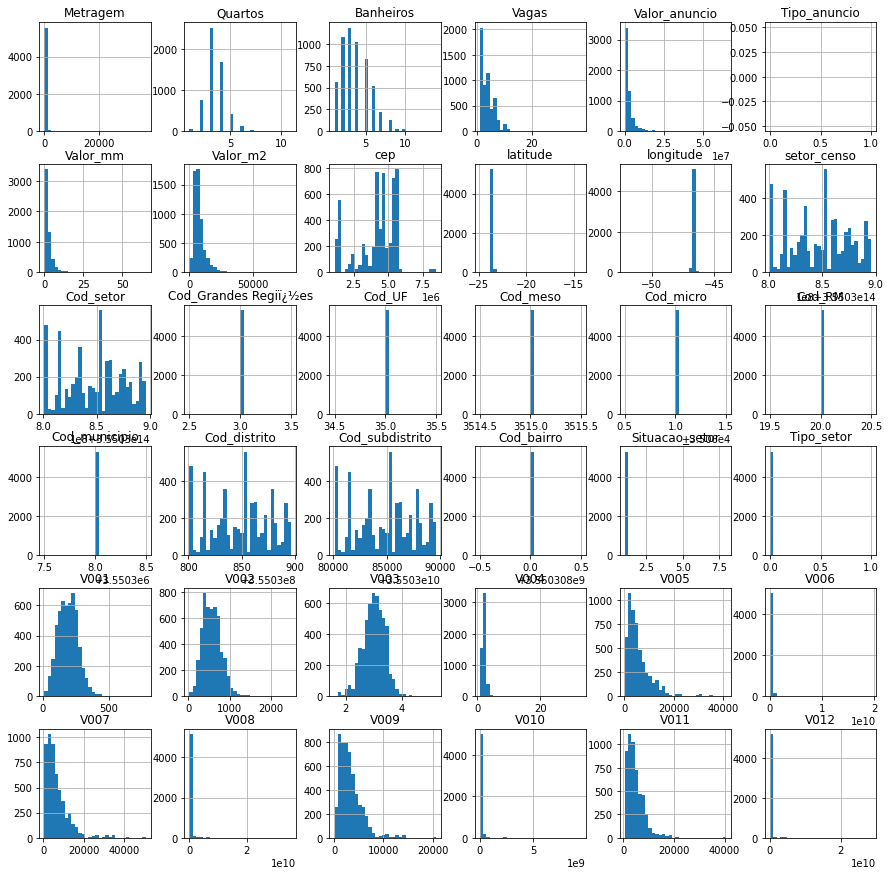

In [ ]:
dados_vendas_censo_alura.hist(bins=30, figsize=(15,15))
plt.show()

In [ ]:
# Note que são poucas variáveis que se assemelham a uma distribuição gaussiana, então vamos tentar ajustar isso aplicando transformações
# Por enquanto, o dataset precisa de uma poda


In [ ]:
useless_list = useless_variables(dados_vendas_censo_alura)
useless_list

['Cidade',
 'Tipo_anuncio',
 'Cod_Grandes Regiï¿½es',
 'Nome_Grande_Regiao',
 'Cod_UF',
 'Nome_da_UF ',
 'Cod_meso',
 'Nome_da_meso',
 'Cod_micro',
 'Nome_da_micro',
 'Cod_RM',
 'Nome_da_RM',
 'Cod_municipio',
 'Nome_do_municipio',
 'Cod_bairro',
 'Nome_do_bairro']

In [ ]:
dados_vendas_censo_alura.drop(useless_list, axis = 1, inplace = True)

In [ ]:
dados_vendas_censo_alura

,Rua,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_anuncio,Valor_mm,Valor_m2,rua,cep,latitude,longitude,Point,setor_censo,Cod_setor,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,1000,4,8,6,R$ 7.000.000,7000000.00,7.00,7000.00,Avenida Itacira,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00,355030877000067.00,355030877.00,SAï¿½DE,35503087700.00,SAï¿½DE,1.00,0.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,496,4,4,4,R$ 3.700.000,3700000.00,3.70,7459.68,Rua Aurelia Perez Alvarez,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00,355030871000023.00,355030871.00,SANTO AMARO,35503087100.00,SANTO AMARO,1.00,0.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,125,4,3,2,R$ 380.000,380000.00,0.38,3040.00,Rua Alba Valdez,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00,355030830000050.00,355030830.00,GRAJAï¿½,35503083000.00,GRAJAï¿½,1.00,0.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,100,3,2,2,R$ 540.000,540000.00,0.54,5400.00,Rua Tobias Barreto,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00,355030808000050.00,355030808.00,BELï¿½M,35503080800.00,BELï¿½M,1.00,0.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,440,4,4,6,R$ 1.980.000,1980000.00,1.98,4500.00,Rua Graham Bell,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00,355030865000169.00,355030865.00,RAPOSO TAVARES,35503086500.00,RAPOSO TAVARES,1.00,0.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600,Avenida Odila,Planalto Paulista,267,3,6,4,R$ 1.500.000,1500000.00,1.50,5617.98,Avenida Odila,4058020.00,-23.61,-46.65,POINT (-46.6472577 -23.6090928),355030877000099.00,355030877000099.00,355030877.00,SAï¿½DE,35503087700.00,SAï¿½DE,1.00,0.00,256.00,720.00,2.81,1.60,4249.33,24499871.44,5180.14,25047413.33,2618.76,17705032.31,3977.93,21495997.85
5601,Rua Tapuçu,Vila Sofia,95,2,2,2,R$ 665.000,665000.00,0.67,7000.00,Rua Tapuçu,4671185.00,-23.66,-46.69,POINT (-46.6915206 -23.661018),355030816000087.00,355030816000087.00,355030816.00,CAMPO GRANDE,35503081600.00,CAMPO GRANDE,1.00,0.00,150.00,448.00,2.99,1.81,2425.09,6878872.25,2543.80,6913867.79,1561.58,4261814.01,2062.09,4596759.57
5602,Rua Guararema,Bosque da Saúde,605,8,7,5,R$ 2.300.000,2300000.00,2.30,3801.65,Rua Guararema,4136030.00,-23.41,-46.04,POINT (-46.0373872 -23.411688),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5603,Rua Estero Belaco,Vila da Saúde,205,3,3,6,R$ 1.050.000,1050000.00,1.05,5121.95,Rua Estero Belaco,4145020.00,-23.62,-46.63,POINT (-46.632983 -23.6161237),355030877000052.00,355030877000052.00,355030877.00,SAï¿½DE,35503087700.00,SAï¿½DE,1.00,0.00,400.00,1099.00,2.75,1.50,5650.20,20344622.14,5750.84,20127679.27,3459.68,16021825.60,4362.79,16264378.33


In [ ]:
# as features abandonadas aqui ou são muito trabalhosas de se tentarem encaixar em um modelo de regressão, impossíveis ou são irrelevantes.
dropping_features = ['Rua', 'Bairro', 'Valor', 'Valor_m2', 'rua', 'latitude', 'longitude', 'Point', 'Cod_distrito', 
 'Nome_do_distrito', 'Nome_do_subdistrito','Tipo_setor','cep','Cod_setor','setor_censo', 'Cod_subdistrito']

In [ ]:
dados_vendas_censo_alura.drop(dropping_features, axis = 1, inplace = True)

In [ ]:
# verificar se contém valores nulos
vars_num = [var for var in dados_vendas_censo_alura.columns if var != 'valor']
vars_num_com_na = [
    var for var in vars_num
    if dados_vendas_censo_alura[var].isnull().sum() > 0
]
dados_vendas_censo_alura[vars_num_com_na].isnull().mean().sort_values(ascending=False)

Situacao_setor   0.05
V001             0.05
V002             0.05
V003             0.05
V004             0.05
V005             0.05
V006             0.05
V007             0.05
V008             0.05
V009             0.05
V010             0.05
V011             0.05
V012             0.05
dtype: float64

In [ ]:
dados_vendas_censo_alura = dados_vendas_censo_alura[['Metragem', 'Quartos', 'Banheiros', 'Vagas',
       'Valor_anuncio', 'Valor_mm', 'Situacao_setor', 'V001',
       'V002', 'V003', 'V004', 'V005', 'V006', 'V007', 'V008', 'V009', 'V010',
       'V011', 'V012']].dropna()
dados_vendas_censo_alura[vars_num_com_na].isnull().sum()

Situacao_setor    0
V001              0
V002              0
V003              0
V004              0
V005              0
V006              0
V007              0
V008              0
V009              0
V010              0
V011              0
V012              0
dtype: int64

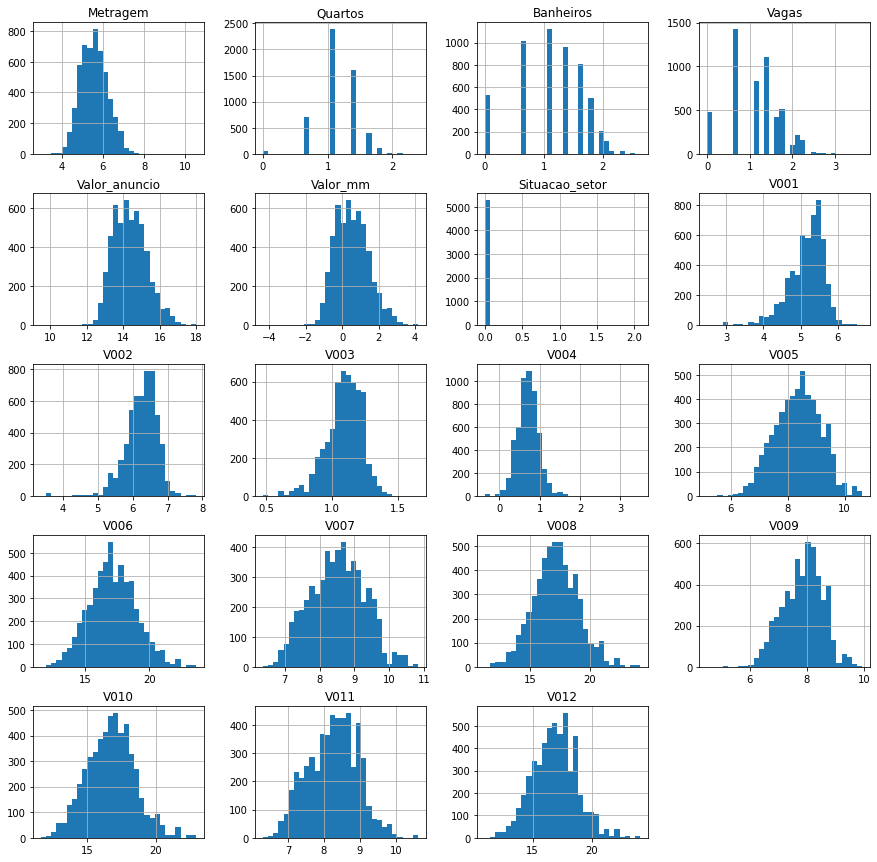

In [ ]:
#criar dataset temporário para não sobrescrever o original
tmp = dados_vendas_censo_alura.copy()

for var in dados_vendas_censo_alura:

    # transformar a variável com logaritmo
    tmp[var] = np.log(dados_vendas_censo_alura[var])

tmp.hist(bins=30, figsize=(15,15))
plt.show()


In [ ]:
# A impressão é que a transformação tornou várias variáveis mais simétricas (perto da gaussiana)

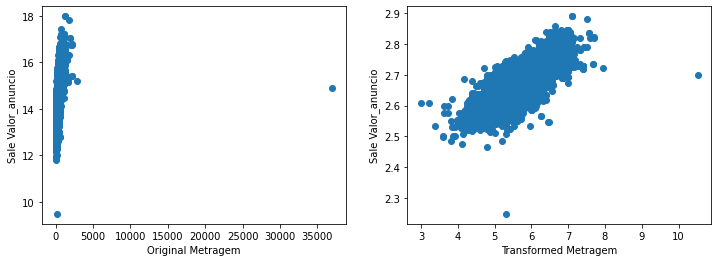

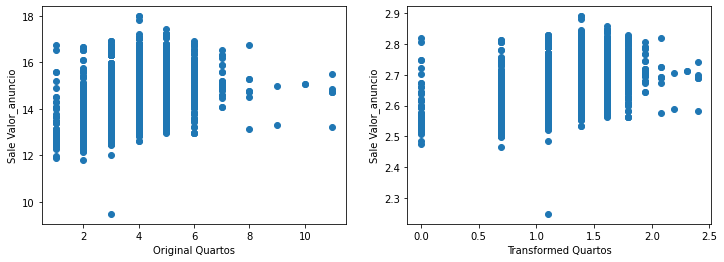

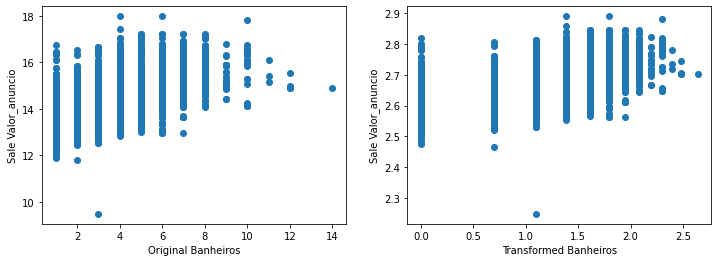

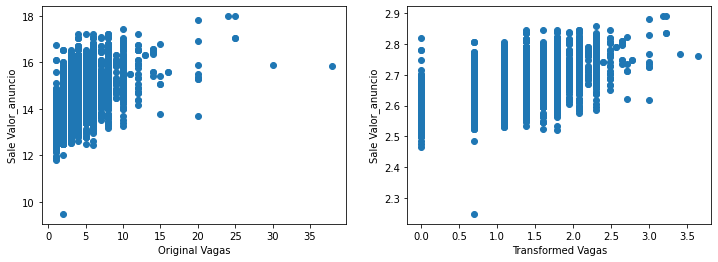

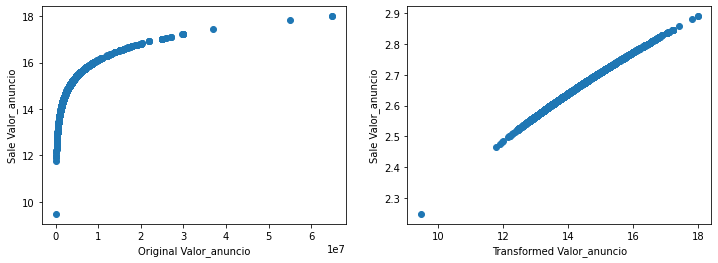

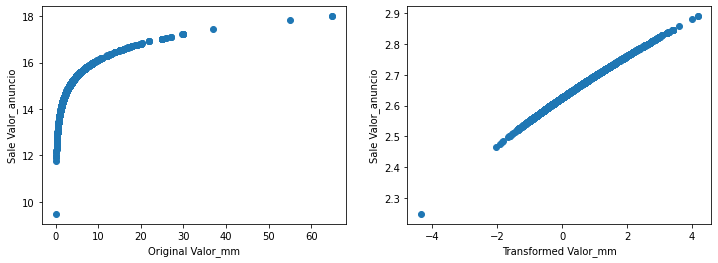

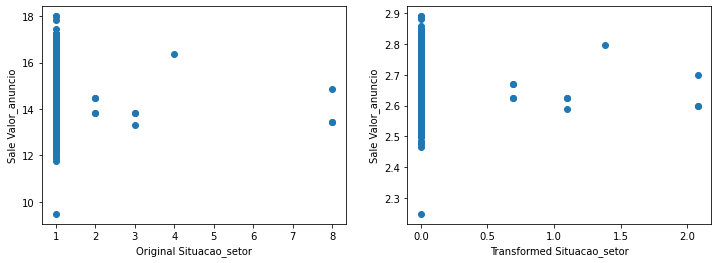

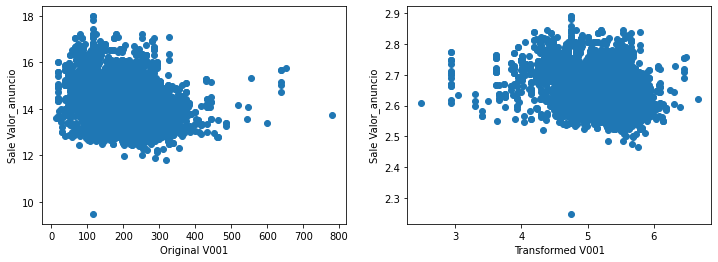

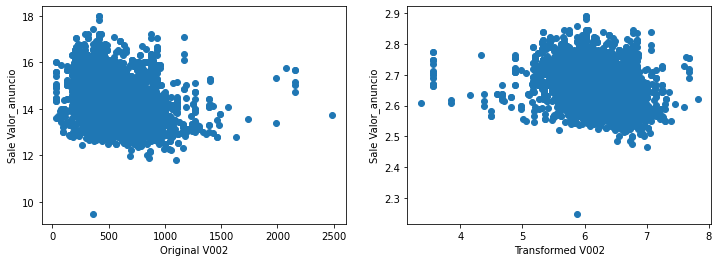

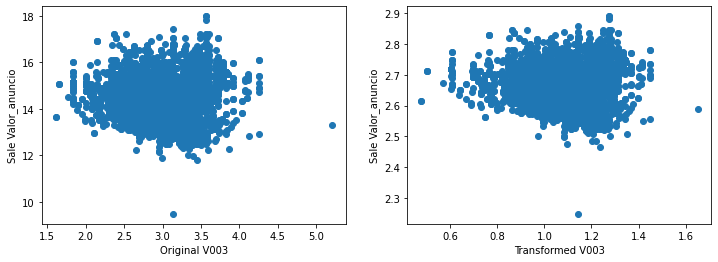

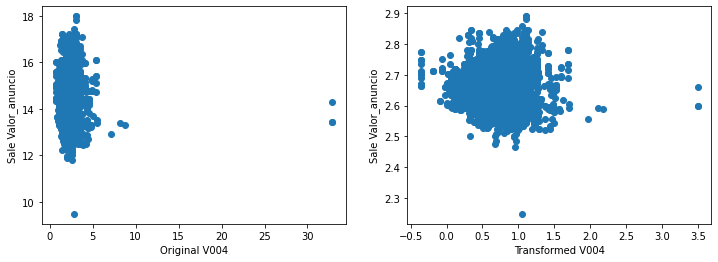

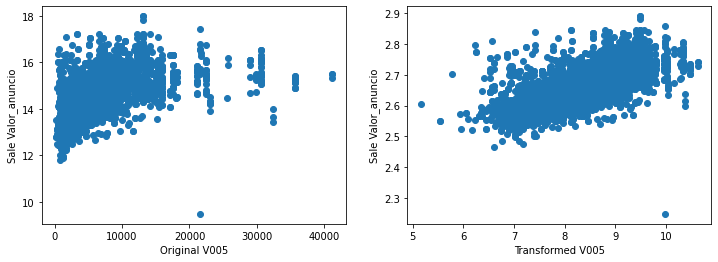

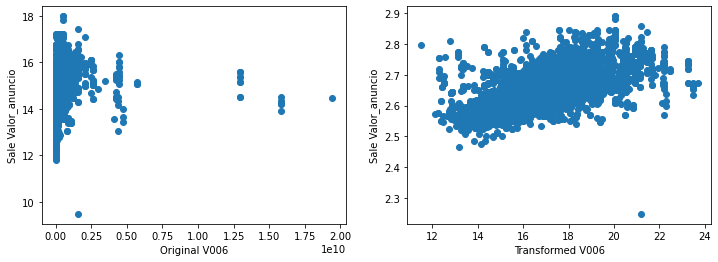

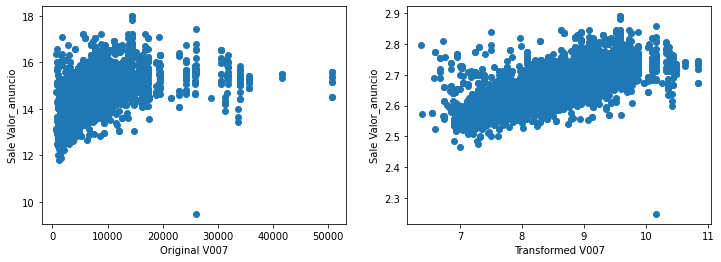

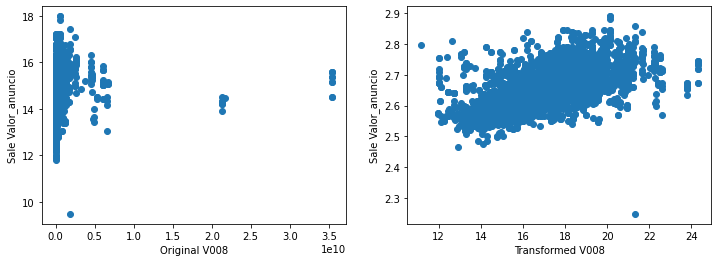

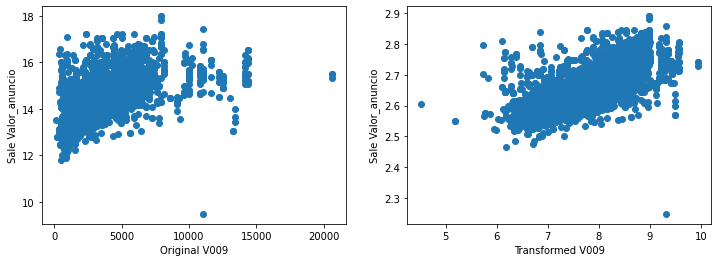

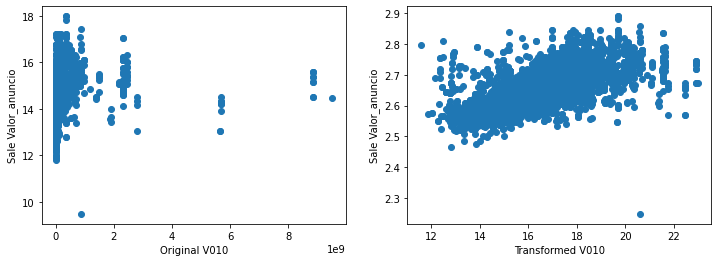

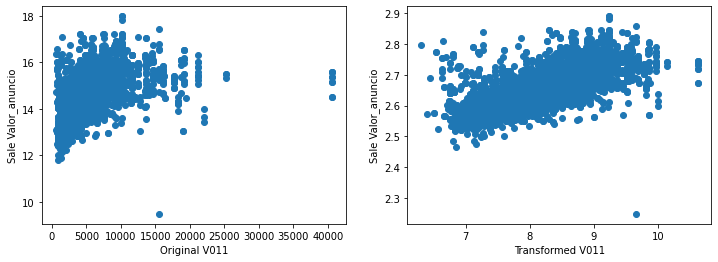

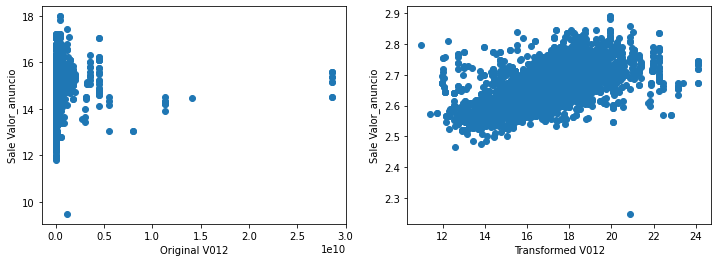

In [ ]:
for var in dados_vendas_censo_alura.columns:
    
    plt.figure(figsize=(12,4))
    
    # plot da variavel original vs preço   
    plt.subplot(1, 2, 1)
    plt.scatter(dados_vendas_censo_alura[var], np.log(dados_vendas_censo_alura['Valor_anuncio']))
    plt.ylabel('Sale Valor_anuncio')
    plt.xlabel('Original ' + var)

    # plot variável transformada vs preço
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['Valor_anuncio']))
    plt.ylabel('Sale Valor_anuncio')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

In [ ]:
# A maior parte das variáveis contínuas transformadas tornaram-se mais bem distribuídas, o que pode ajudar no desempenho do modelo


In [ ]:
dados_vendas_censo_alura

,Metragem,Quartos,Banheiros,Vagas,Valor_anuncio,Valor_mm,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,1000,4,8,6,7000000.00,7.00,1.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,496,4,4,4,3700000.00,3.70,1.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,125,4,3,2,380000.00,0.38,1.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,100,3,2,2,540000.00,0.54,1.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,440,4,4,6,1980000.00,1.98,1.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5599,157,3,2,2,960000.00,0.96,1.00,177.00,384.00,2.17,1.27,5054.58,33245189.73,5231.93,33485189.78,3649.06,26562232.53,4551.66,29032823.35
5600,267,3,6,4,1500000.00,1.50,1.00,256.00,720.00,2.81,1.60,4249.33,24499871.44,5180.14,25047413.33,2618.76,17705032.31,3977.93,21495997.85
5601,95,2,2,2,665000.00,0.67,1.00,150.00,448.00,2.99,1.81,2425.09,6878872.25,2543.80,6913867.79,1561.58,4261814.01,2062.09,4596759.57
5603,205,3,3,6,1050000.00,1.05,1.00,400.00,1099.00,2.75,1.50,5650.20,20344622.14,5750.84,20127679.27,3459.68,16021825.60,4362.79,16264378.33


In [ ]:
dados_vendas_censo_alura.drop(dados_vendas_censo_alura.query("Valor_anuncio > 30000000 | Valor_anuncio < 100000").index, inplace = True)

In [ ]:
X = dados_vendas_censo_alura[['Metragem', 'Quartos','Banheiros','Vagas',
      'V002','V003','V004','V006', 'V008','V010','V011']]

for var in ['V002','V003','V004','V006', 'V008','V010','V011']:
    X[var] = np.log(X[var])
y = dados_vendas_censo_alura['Valor_anuncio']
y = y.to_frame()
y = np.log(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

lin_model = GradientBoostingRegressor(**params)
lin_model.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(max_depth=6, min_samples_split=5)

In [ ]:
# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_absolute_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))

train mse: 445444
train rmse: 910552
train r2: 0.9191757638336396

test mse: 2442126582596
test rmse: 1562730
test r2: 0.7751769325993666


Text(0.5, 1.0, 'Avaliação das predições do modelo')

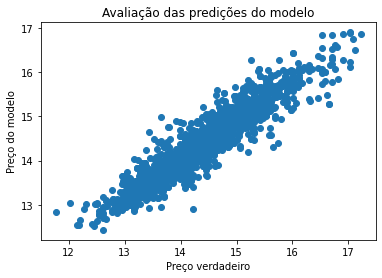

In [ ]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('Preço verdadeiro')
plt.ylabel('Preço do modelo')
plt.title('Avaliação das predições do modelo')

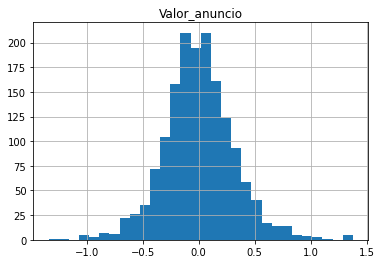

In [ ]:
y_test.reset_index(drop=True, inplace=True)
y_test

preds = pd.DataFrame(lin_model.predict(X_test), columns = ['Valor_anuncio'])
errors = y_test - preds
errors.hist(bins=30)
plt.show()
# O plot passado mostra a proximidade entre o preço verdadeiro e o predito
# enquanto que este plot mostra que há certa simetria (semelhança com a distribuição Normal) nos erros, o que facilita a construção de um intervalo de confiança para o preço.